In [ ]:

!pip install torch torchvision transformers matplotlib scikit-learn




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


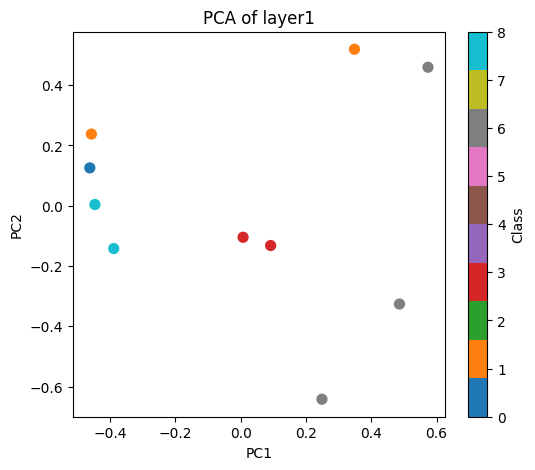

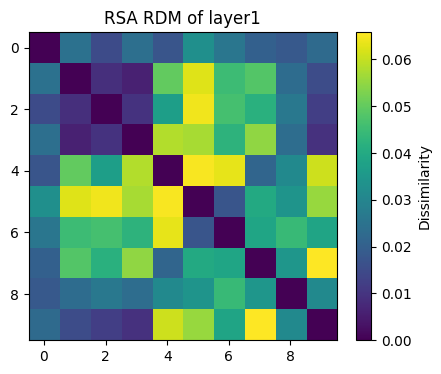

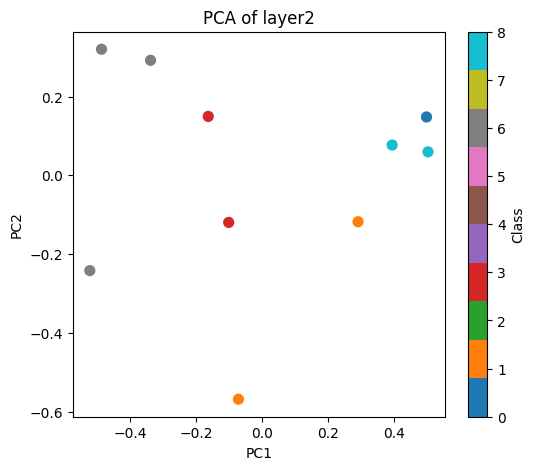

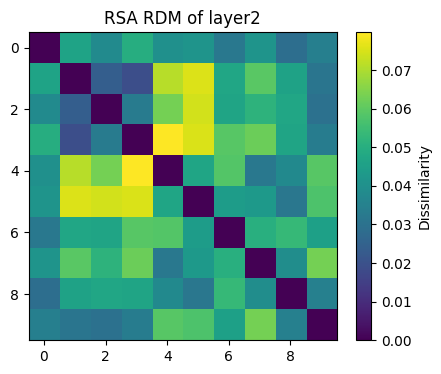

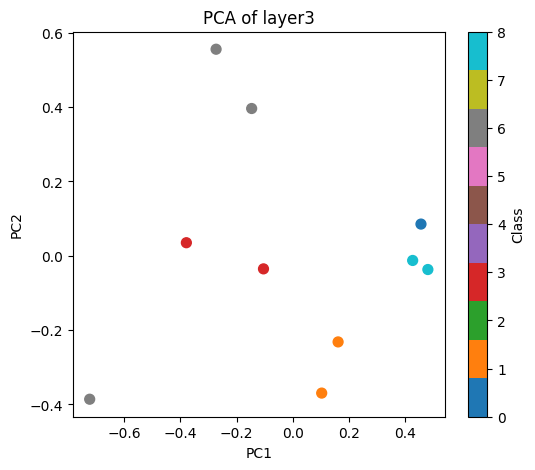

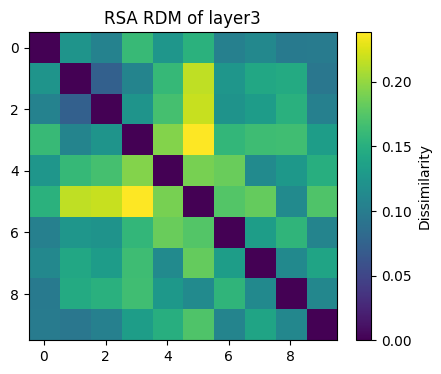

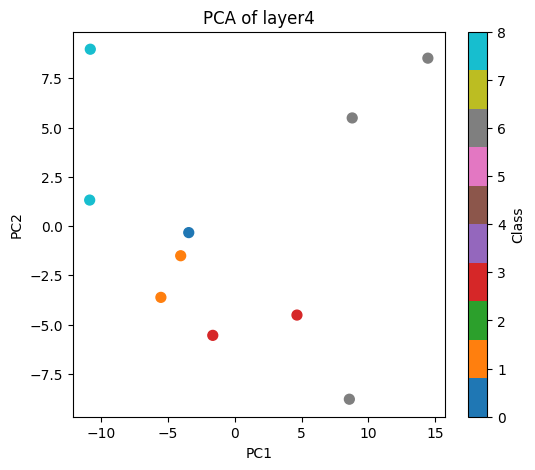

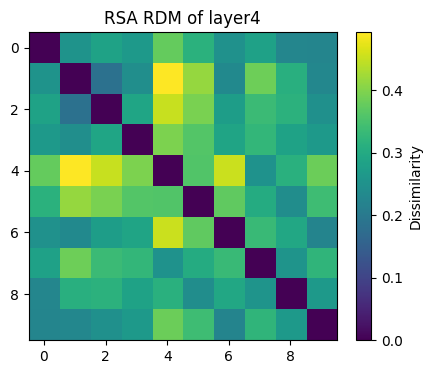

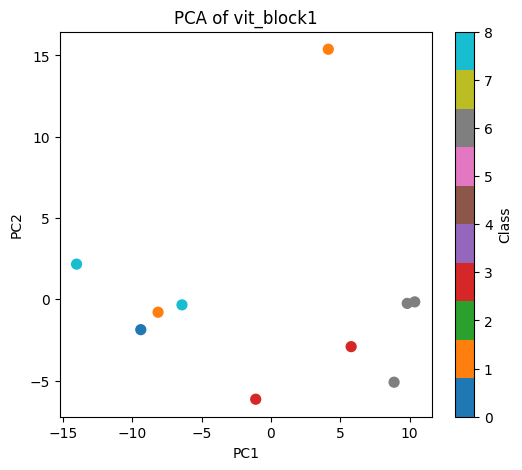

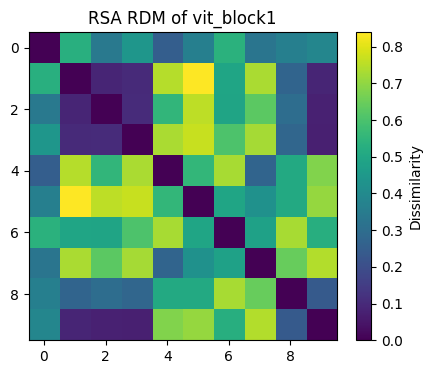

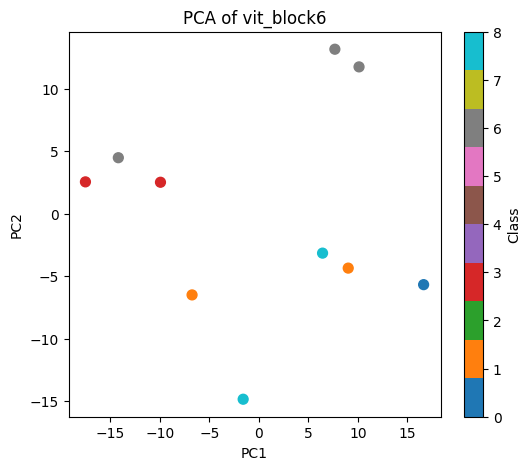

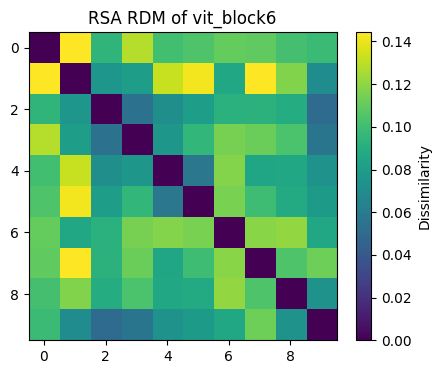

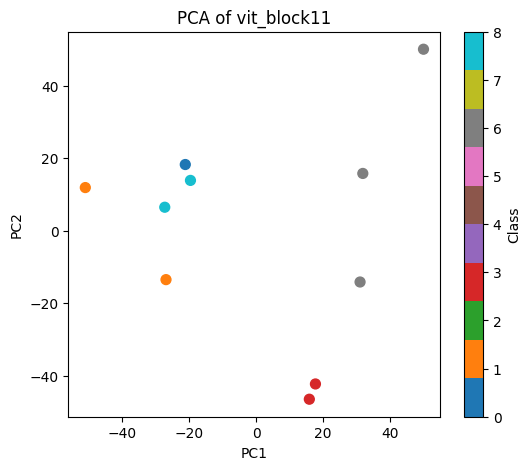

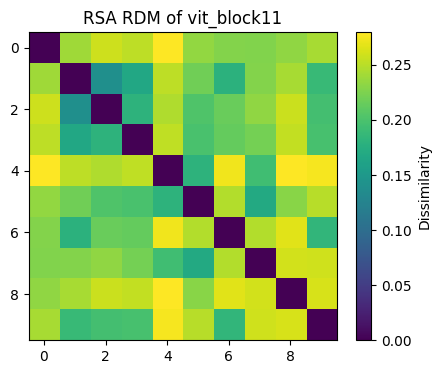

In [10]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from transformers import ViTModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False)
images, labels = next(iter(loader))
images = images.to(device)


resnet = models.resnet50(pretrained=True).to(device).eval()
vit = ViTModel.from_pretrained('google/vit-base-patch16-224', output_hidden_states=True).to(device).eval()


activations = {}
resnet_layers = ['layer1', 'layer2', 'layer3', 'layer4']
vit_indices = [1, len(vit.encoder.layer)//2, len(vit.encoder.layer)-1]

def make_hook(name):
    def hook(_, __, output):
        activations[name] = output.detach()
    return hook

for l in resnet_layers:
    getattr(resnet, l).register_forward_hook(make_hook(l))


with torch.no_grad():
    _ = resnet(images)
    vit_out = vit(pixel_values=images)
    hidden_states = vit_out.hidden_states


profiled = {}
for name in resnet_layers:
    feat = activations[name]
    pooled = F.adaptive_avg_pool2d(feat, 1).reshape(feat.size(0), -1).cpu().numpy()
    profiled[name] = pooled

for idx in vit_indices:
    hs = hidden_states[idx]
    pooled = hs[:, 1:, :].mean(dim=1).cpu().numpy()
    profiled[f'vit_block{idx}'] = pooled


def plot_pca_rsa(name, data, labels):
    #PCA
    pca = PCA(n_components=2)
    emb = pca.fit_transform(data)
    plt.figure(figsize=(6,5))
    plt.scatter(emb[:,0], emb[:,1], c=labels, cmap='tab10', s=50)
    plt.title(f"PCA of {name}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.colorbar(ticks=range(10), label='Class')
    plt.show()
    #RSA
    norm = data / np.linalg.norm(data, axis=1, keepdims=True)
    sim = np.dot(norm, norm.T)
    rdm = 1 - sim
    plt.figure(figsize=(5,4))
    plt.imshow(rdm, cmap='viridis')
    plt.title(f"RSA RDM of {name}")
    plt.colorbar(label='Dissimilarity')
    plt.show()

#layers
for name, feats in profiled.items():
    plot_pca_rsa(name, feats, labels.cpu().numpy())
